In [2]:
import mappy
import matplotlib.pyplot as plt
import numpy as np
import pysam
import pandas as pd
from utils_script import *
from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [3]:
ref_path = "/data1/YHC/QiTan_data/ara/Sturgeon/ARA.SEQUELII.hifiasm.p_ctg.fasta"
fastq_path = "/data1/YHC/QiTan_data/ara/Sturgeon_2/pass.fastq"

In [4]:
ref_genome = mappy.Aligner(ref_path)

In [5]:
cnt = 0
mean_quality = []
seq_lens = []
for line in open("/data1/YHC/QiTan_data/ara/Sturgeon_2/pass.fastq"):
    if cnt % 4 == 0:
        # print(line)
        line_s = line.strip().split("\t")
        mean_quality.append(int(line_s[1][5:]))
        # break
    if cnt % 4 == 1:
        seq_lens.append(len(line))
        # first_hit = next(ref_genome.map(line.strip()), None)
        # if first_hit is None: continue
    cnt += 1
seq_lens.sort()

In [10]:
def draw(values):
    plt.figure(figsize=(10, 6))

    # 绘制直方图，设置颜色和透明度
    plt.hist(values, bins=50, color='skyblue', edgecolor='black', alpha=0.7)

    # 添加标题和标签
    # plt.title("Distribution of Mean Quality", fontsize=16)
    # plt.xlabel("Quality", fontsize=14)
    # plt.ylabel("Frequency", fontsize=14)

    # 添加网格
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # 添加参考线（例如平均值）
    mean_value = sum(values) / len(values)
    plt.axvline(mean_value, color='red', linestyle='--', linewidth=1.5, label=f"Mean: {mean_value:.2f}")
    plt.legend()

    # 优化刻度
    # plt.xticks(range(min(values), max(values) + 1, 2), fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

In [28]:
TN, FN = 0, 0
off_loc_2 = []
for line in open("/data1/YHC/QiTan_data/Fruitfly/YF6419_h5/Sturgeon_2/mod_result.txt"):
    line_s = line.strip().split("\t")
    if float(line_s[-1]) <= 0.5:
        TN += 1
    else:
        FN += 1
    # if line_s[0] == "035E29E6-0FC1-4541-BD63-403537636ACF":
    off_loc_2.append("\t".join(line_s[:-1]))
print(TN / (TN + FN))
off_loc_2 = list(set(off_loc_2))
off_loc_2.sort()
print(len(off_loc_2))

0.9596163140035419
64093035


In [6]:
def get_pos_rate(file_path):
    pos_rate = []
    high_error_site = {}
    for line in open(file_path,'r'):
        # print(line)
        # break
        line_s = line.strip().split(",")
        key = ",".join(line_s[:-3])
        # print(key)
        # break
        high_error_site[key] = (int(line_s[-2]) , int(line_s[-1]))
    TP, FP = 0, 0
    for line in open("/data1/YHC/QiTan_data/Fruitfly/YF6418_h5/Sturgeon_2/mod_result.txt",'r'):
        line_s = line.strip().split("\t")
        key = ",".join([line_s[0], line_s[3], line_s[1]])
        if key in high_error_site.keys():
            st, ed = high_error_site[key]
            if int(line_s[4]) >= st and int(line_s[4]) <= ed:
                if float(line_s[-1]) > 0.5:
                    TP += 1
                else:
                    FP += 1
                pos_rate.append(float(line_s[-1]))
    print("TPR: ", TP / (TP + FP))
    return pos_rate

def get_neg_rate(file_path):
    neg_rate = []
    high_error_site = {}
    for line in open(file_path, 'r'):
        # print(line)
        # break
        line_s = line.strip().split(",")
        key = ",".join(line_s[:-3])
        # print(key)
        # break
        high_error_site[key] = (int(line_s[-2]) , int(line_s[-1]))
    TN, FN = 0, 0
    for line in open("/data1/YHC/QiTan_data/Fruitfly/YF6419_h5/Sturgeon_2/mod_result.txt",'r'):
        line_s = line.strip().split("\t")
        key = ",".join([line_s[0], line_s[3], line_s[1]])
        if key in high_error_site.keys():
            st, ed = high_error_site[key]
            if int(line_s[4]) >= st and int(line_s[4]) <= ed:
                if float(line_s[-1]) <= 0.5:
                    TN += 1
                else:
                    FN += 1
                neg_rate.append(float(line_s[-1]))
    print("TFR: ", TN / (TN + FN))
    return neg_rate

In [7]:
def get_roc(file_path_pos, file_path_neg):
    pos_rate = get_pos_rate(file_path_pos)
    neg_rate = get_neg_rate(file_path_neg)
    min_len = min(len(pos_rate), len(neg_rate))
    np.random.shuffle(pos_rate)
    np.random.shuffle(neg_rate)
    probs = pos_rate[:min_len] + neg_rate[:min_len]
    target = np.zeros(len(probs))
    target[:min_len] = 1
    return target, probs

In [8]:
target_1, probs_1 = get_roc("/data1/YHC/QiTan_data/Fruitfly/YF6418_h5/Sturgeon_2/high_err_loc_0_0.05.txt",
                            "/data1/YHC/QiTan_data/Fruitfly/YF6419_h5/Sturgeon_2/high_err_loc_0_0.05.txt")
target_2, probs_2 = get_roc("/data1/YHC/QiTan_data/Fruitfly/YF6418_h5/Sturgeon_2/high_err_loc_0.05_0.1.txt",
                            "/data1/YHC/QiTan_data/Fruitfly/YF6419_h5/Sturgeon_2/high_err_loc_0.05_0.1.txt")
target_3, probs_3 = get_roc("/data1/YHC/QiTan_data/Fruitfly/YF6418_h5/Sturgeon_2/high_err_loc_0.1_0.15.txt",
                            "/data1/YHC/QiTan_data/Fruitfly/YF6419_h5/Sturgeon_2/high_err_loc_0.1_0.15.txt")
target_4, probs_4 = get_roc("/data1/YHC/QiTan_data/Fruitfly/YF6418_h5/Sturgeon_2/high_err_loc_0.15_0.2.txt",
                            "/data1/YHC/QiTan_data/Fruitfly/YF6419_h5/Sturgeon_2/high_err_loc_0.15_0.2.txt")
target_5, probs_5 = get_roc("/data1/YHC/QiTan_data/Fruitfly/YF6418_h5/Sturgeon_2/high_err_loc_0.2_0.25.txt",
                            "/data1/YHC/QiTan_data/Fruitfly/YF6419_h5/Sturgeon_2/high_err_loc_0.2_0.25.txt")
target_6, probs_6 = get_roc("/data1/YHC/QiTan_data/Fruitfly/YF6418_h5/Sturgeon_2/high_err_loc_0.25_0.3.txt",
                            "/data1/YHC/QiTan_data/Fruitfly/YF6419_h5/Sturgeon_2/high_err_loc_0.25_0.3.txt")
target_7, probs_7 = get_roc("/data1/YHC/QiTan_data/Fruitfly/YF6418_h5/Sturgeon_2/high_err_loc_0.3_1.txt",
                            "/data1/YHC/QiTan_data/Fruitfly/YF6419_h5/Sturgeon_2/high_err_loc_0.3_1.txt")

TPR:  0.905667195296902
TFR:  0.9375109641481367
TPR:  0.9369445788100156
TFR:  0.9667030971141036
TPR:  0.9307029406893386
TFR:  0.9543027019458893
TPR:  0.9066548585306174
TFR:  0.9144109536163785
TPR:  0.8755782274001663
TFR:  0.8714103860122057
TPR:  0.854266869291388
TFR:  0.8345936549326379
TPR:  0.7054401081263727
TFR:  0.7036434923974372


0.9561732932976785
0.9806734788352524
0.9784296144768501
0.9666734149315153
0.947579063496899
0.9300885211935705
0.7878967569196819


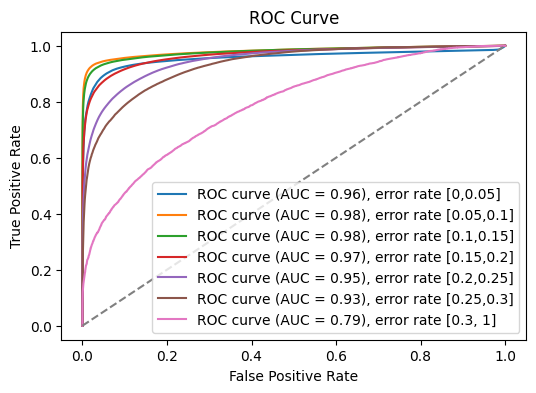

In [9]:
plt.figure(figsize=(6, 4))

fpr, tpr, thresholds = roc_curve(target_1, probs_1)
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f}), error rate [0,0.05]')

fpr, tpr, thresholds = roc_curve(target_2, probs_2)
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f}), error rate [0.05,0.1]')

fpr, tpr, thresholds = roc_curve(target_3, probs_3)
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f}), error rate [0.1,0.15]')

fpr, tpr, thresholds = roc_curve(target_4, probs_4)
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f}), error rate [0.15,0.2]')

fpr, tpr, thresholds = roc_curve(target_5, probs_5)
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f}), error rate [0.2,0.25]')

fpr, tpr, thresholds = roc_curve(target_6, probs_6)
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f}), error rate [0.25,0.3]')

fpr, tpr, thresholds = roc_curve(target_7, probs_7)
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f}), error rate [0.3, 1]')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig("fig5_4", dpi=400, bbox_inches="tight")
plt.show()

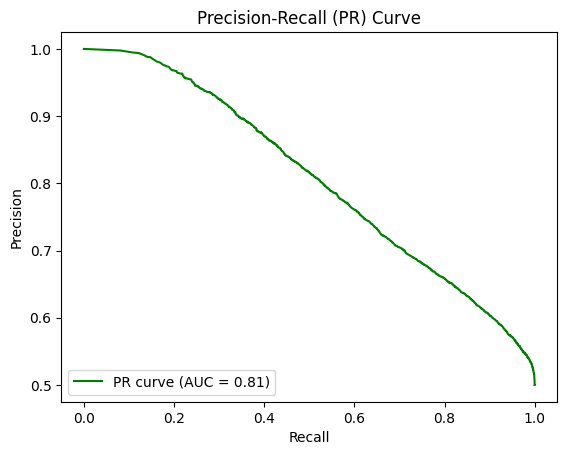

In [70]:
precision, recall, thresholds = precision_recall_curve(target, probs)
pr_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='green', label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curve')
plt.legend(loc="lower left")
plt.show()


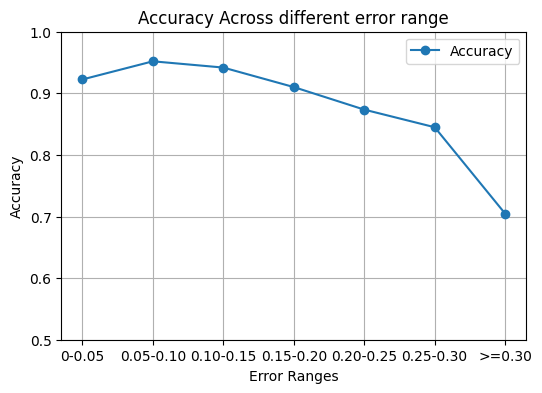

In [10]:
import matplotlib.pyplot as plt

# Accuracy values and thresholds from the table
thresholds = [0.0, 0.05, 0.10, 0.15, 0.2, 0.25, 0.3]
accuracy = [0.9225204, 0.951975, 0.941813, 0.910149, 0.873558, 0.844941, 0.704696]

# Create a line plot
plt.figure(figsize=(6, 4))
plt.plot(thresholds, accuracy, marker='o', linestyle='-', label='Accuracy')
plt.title("Accuracy Across different error range")
plt.xlabel("Error Ranges")
plt.ylabel("Accuracy")
plt.xticks(thresholds, labels=['0-0.05', '0.05-0.10', '0.10-0.15', '0.15-0.20', '0.20-0.25', '0.25-0.30', '>=0.30'])
plt.ylim(0.5, 1)
plt.grid(True)
plt.legend()
plt.savefig("fig5_3", dpi=400, bbox_inches="tight")
plt.show()

In [11]:
import os.path

import mappy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pysam
# from utils.utils_func import *

# f = open("/data1/YHC/QiTan_data/Fruitfly/YF6418_h5/Sturgeon_2/high_err_loc.txt", 'w')
def counter(path, filter_err : list = [0, 1]):
    f = open(os.path.join(os.path.dirname(path), "high_err_loc_{}_{}.txt".format(filter_err[0], filter_err[1])), 'w')
    bam_file = pysam.AlignmentFile(path, 'r', threads=10)
    mapped_reads, total_reads = 0, 0
    total_error_rate = []
    total_seq_len = []
    total_error_list = []
    total_qual_list = []
    # cnt = 0
    for read in tqdm(bam_file):
        total_reads += 1
        if total_reads >= 100000: break
        if read.is_unmapped: continue

        if read.query_sequence is None or len(read.query_alignment_sequence) <= 2000:
            continue
        query_seq = read.query_sequence
        ref_seq = read.get_reference_sequence()
        mapped_reads += 1
        M = 0
        insert, delete, soft_clip, hard_clip = 0, 0, 0, 0
        seq_len, ref_len = 0, 0
        num_ins, num_del = 0, 0
        mis_match_list = []
        insert_list = []
        delete_list = []
        qual_list = []
        cnt_curr = 500
        rate_mis_match_bp = 0
        rate_insert_bp = 0
        rate_delete_bp = 0
        base_ref_cnt = 0
        base_query_cnt = 0

        # if read.query_name != "0CE9E98D-4F9C-4AA6-B09A-48737101CFF9": continue
        for (op, op_len) in read.cigar:
            ref_len_pre = ref_len
            if op == 0:
                M += op_len
                for i in range(op_len):
                    if query_seq[seq_len + i] != ref_seq[ref_len + i]:
                        rate_mis_match_bp += 1
                seq_len += op_len
                ref_len += op_len
            elif op == 1:
                insert += op_len
                num_ins += 1
                rate_insert_bp += 1
                seq_len += op_len
            elif op == 2:
                delete += op_len
                num_del += 1
                rate_delete_bp += 1
                ref_len += op_len
            elif op == 4:
                soft_clip += op_len
                seq_len += op_len
            elif op == 5:
                hard_clip += op_len
            else:
                print("find other tag-{}".format(op))
            if ref_len > ref_len_pre and ref_len >= cnt_curr:  # 达到500bp的长度
                cnt_curr = min(cnt_curr + 500, len(ref_seq))
                if (ref_len - base_ref_cnt) <= 300: continue
                temp_mis_match = rate_mis_match_bp / (ref_len - base_ref_cnt)
                temp_insert = rate_insert_bp / (ref_len - base_ref_cnt)
                temp_delete = rate_delete_bp / (ref_len - base_ref_cnt)

                mis_match_list.append(temp_mis_match)
                insert_list.append(temp_insert)
                delete_list.append(temp_delete)
                qual_list.append(np.mean(read.query_qualities[base_query_cnt : base_query_cnt + seq_len]))
                if (temp_mis_match + temp_delete + temp_insert) >= filter_err[0] and (temp_mis_match + temp_delete + temp_insert) < filter_err[1]:
                    # print("Find high error rate subseq, read: {}, ref name: {}, relative loc: [{}, {}] ".format(
                    #     read.query_name, read.reference_name, base_cnt, ref_len
                    # ))
                    f.write("{},{},{},{},{},{}\n".format(read.query_name,
                                                      read.reference_name,
                                                      read.reference_start,
                                                      read.reference_end,
                                                      read.reference_start + base_ref_cnt,
                                                      read.reference_start + ref_len))
                base_ref_cnt = ref_len
                base_query_cnt = seq_len
                rate_mis_match_bp = 0
                rate_insert_bp = 0
                rate_delete_bp = 0
        try:
            NM = read.get_tag("NM")  # mismatches, inserted, deleted
        except:
            continue  # skip reads that have no tags
        mis_match = (NM - insert - delete)
        assert len(mis_match_list) == len(insert_list) == len(delete_list)
        error_list = (np.array(mis_match_list) + np.array(insert_list) + np.array(delete_list))
        total_error_list.append(error_list)
        total_qual_list.append(np.array(qual_list))
        error_rate = (mis_match + num_ins + num_del) / ref_len
        total_error_rate.append(error_rate)
        total_seq_len.append(seq_len)
    f.close()
    return (total_error_rate, total_error_list, total_qual_list
            # , high_err_loc_fraction, total_seq_len
            )

total_error_rate1, total_error_list1, total_qual_list1 = counter("/data1/YHC/QiTan_data/ara/Sturgeon_2/alignment.bam")
total_error_rate2, total_error_list2, total_qual_list2 = counter("/data1/YHC/QiTan_data/oryza/Sturgeon_2/alignment.bam")
total_error_rate3, total_error_list3, total_qual_list3 = counter("/data1/YHC/QiTan_data/Fruitfly/YF6418_h5/Sturgeon_2/alignment.bam",
                                               # [0, 0.05]
                                               )
total_error_rate4, total_error_list4, total_qual_list4 = counter("/data1/YHC/QiTan_data/Fruitfly/YF6419_h5/Sturgeon_2/alignment.bam",
                                               # [0, 0.05]
                                               )

print(np.mean([np.corrcoef(x, y)[0][1] for x, y in zip(total_error_list1, total_qual_list1) if len(x) >= 2]))
print(np.mean([np.corrcoef(x, y)[0][1] for x, y in zip(total_error_list2, total_qual_list2) if len(x) >= 2]))
print(np.mean([np.corrcoef(x, y)[0][1] for x, y in zip(total_error_list3, total_qual_list3) if len(x) >= 2]))
print(np.mean([np.corrcoef(x, y)[0][1] for x, y in zip(total_error_list4, total_qual_list4) if len(x) >= 2]))


99999it [00:33, 2984.48it/s]
99999it [00:45, 2178.84it/s]
99999it [00:07, 12760.37it/s]
99999it [00:07, 13368.98it/s]


-0.4079451339749956
-0.438839411413136
-0.33418398649402914
-0.3179014165746589


In [12]:
def get_error_dict(total_error_list, total_qual_list):
    error_dict = {}
    for i in range(len(total_qual_list)):
        for j in range(len(total_qual_list[i])):
            qual = int(total_qual_list[i][j])
            error = total_error_list[i][j]
            if qual not in error_dict.keys():
                error_dict[qual] = []
            error_dict[qual].append(error)
    x = np.sort(list(error_dict.keys()))
    y = [np.mean(error_dict[qual]) for qual in x]
    # print(error_dict[32])
    return x, y

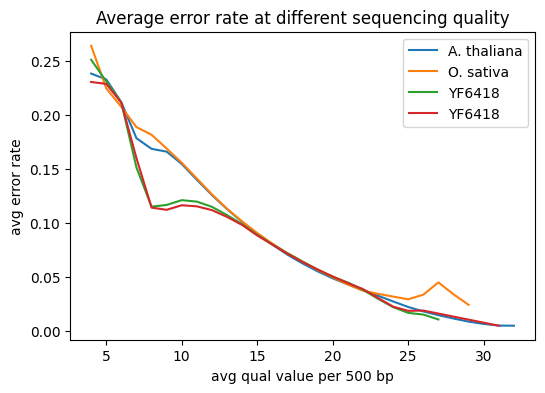

In [13]:
plt.figure(figsize=(6, 4))
(x1, y1) = get_error_dict(total_error_list1, total_qual_list1)
plt.plot(x1, y1 , label = "A. thaliana")
(x2, y2) = get_error_dict(total_error_list2, total_qual_list2)
plt.plot(x2, y2 , label = "O. sativa")
(x3, y3) = get_error_dict(total_error_list3, total_qual_list3)
plt.plot(x3, y3 , label = "YF6418")
(x4, y4) = get_error_dict(total_error_list4, total_qual_list4)
plt.plot(x4, y4 , label = "YF6418")
plt.xlabel("avg qual value per 500 bp")
plt.ylabel("avg error rate")
plt.legend()
plt.title("Average error rate at different sequencing quality")
plt.savefig("fig5_2", dpi=400, bbox_inches="tight")

plt.show()